In [1]:
## this is JP's experimental workbook v2.
## Please do not modify this file - you are welcome to save a copy
## for yourself

In [2]:
import os, sys, keras, copy
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [3]:
from graphTools import *
from layerTools import *

In [4]:

# Read in graphs
graph_files = glob.glob('qm9graph/*.csv')[0:10000]
mygraphs = [readgraph(fname) for fname in graph_files]
headers_onehot_dict, matrices_onehot_dict, mygraphs_standardized = standardize_graphs(mygraphs, max_size=29)
headers_padded = np.array([i['header'] for i in mygraphs_standardized])
matrices_padded = np.array([i['matrix'] for i in mygraphs_standardized])
connectivities_padded = np.array([i['connectivity'] for i in mygraphs_standardized])
origHeaders_padded = np.array([i['origHeader'] for i in mygraphs_standardized])
origMatrices_padded = np.array([i['origMatrix'] for i in mygraphs_standardized])
print headers_padded.shape
print matrices_padded.shape
print connectivities_padded.shape

Header One-Hot Map: {8.0: array([0., 0., 0., 1., 0.]), 1.0: array([1., 0., 0., 0., 0.]), 9.0: array([0., 0., 0., 0., 1.]), 6.0: array([0., 1., 0., 0., 0.]), 7.0: array([0., 0., 1., 0., 0.])}
Bond One-Hot Map: {1.0: array([1., 0., 0.]), 2.0: array([0., 1., 0.]), 3.0: array([0., 0., 1.])}
Graph Size: 29
Number of dropped graphs: 0
(10000, 29, 5)
(10000, 29, 29, 3)
(10000, 29, 29)


In [5]:
from layerTools import generate_gc_atom_layer
inital_atom_layer_1 = generate_gc_atom_layer(num_nodes=29, atom_hidden_length=5, bond_hidden_length=3, hide_atoms=False,\
                      message_dense_resize=5, atom_dense_resize=None,  nonlinear_state_update = False)
dense_read = keras.layers.Dense(32,activation='relu')(inital_atom_layer_1.output)
softmax_ouput = keras.layers.Dense(5,activation='softmax')(dense_read)


final_model = keras.models.Model(inputs=inital_atom_layer_1.inputs, outputs=[softmax_ouput])

Instructions for updating:
Colocations handled automatically by placer.
combined shape is (?, 29, 10)
bond_hiddens_input shape is (?, 29, 29, 3)
atom_hiddens_input shape is (?, 29, 5)
connectivity_input shape is (?, 29, 29)
message_to_out shape is (?, 29, 5)


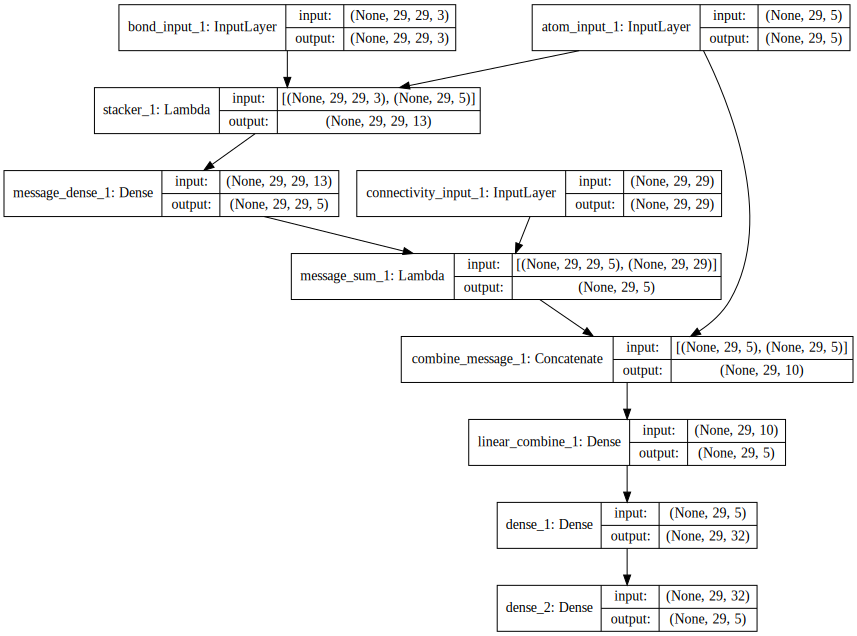

In [6]:

SVG(model_to_dot(final_model,show_shapes=True).create(prog='dot', format='svg'))


In [7]:
np.random.seed(3)
# get random partition
msk = np.random.rand(np.shape(headers_padded)[0]) < 0.75
# test and train split
train_matrices_padded = matrices_padded[msk,:,:]
train_headers_padded = headers_padded[msk,:]
train_connectivities_padded = connectivities_padded[msk,:,:]
test_matrices_padded = matrices_padded[~msk,:,:]
test_headers_padded = headers_padded[~msk,:]
test_connectivities_padded = connectivities_padded[~msk,:,:]

In [8]:
test_matrices_padded.shape

(2476, 29, 29, 3)

In [9]:
final_model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy','categorical_crossentropy'])

train_res = final_model.fit([train_matrices_padded, 
                             train_headers_padded*0.0, train_connectivities_padded],
                            train_headers_padded, epochs=75, 
                            batch_size=100,
                            validation_split=0.1,
                            verbose=True)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 6771 samples, validate on 753 samples
Epoch 1/75
6771/6771 [==============================] - 2s 278us/step - loss: 0.8659 - categorical_accuracy: 0.5535 - categorical_crossentropy: 0.8659 - val_loss: 0.6931 - val_categorical_accuracy: 0.6102 - val_categorical_crossentropy: 0.6931
Epoch 2/75
6771/6771 [==============================] - 1s 77us/step - loss: 0.6139 - categorical_accuracy: 0.8614 - categorical_crossentropy: 0.6139 - val_loss: 0.5279 - val_categorical_accuracy: 0.9156 - val_categorical_crossentropy: 0.5279
Epoch 3/75
6771/6771 [==============================] - 1s 78us/step - loss: 0.4466 - categorical_accuracy: 0.9150 - categorical_crossentropy: 0.4466 - val_loss: 0.3633 - val_categorical_accuracy: 0.9156 - val_categorical_crossentropy: 0.3633
Epoch 4/75
6771/6771 [==============================] - 1s 77us/step - loss: 0.3153 - categorical

6771/6771 [==============================] - 0s 71us/step - loss: 0.0227 - categorical_accuracy: 0.9954 - categorical_crossentropy: 0.0227 - val_loss: 0.0224 - val_categorical_accuracy: 0.9957 - val_categorical_crossentropy: 0.0224
Epoch 33/75
6771/6771 [==============================] - 1s 77us/step - loss: 0.0226 - categorical_accuracy: 0.9954 - categorical_crossentropy: 0.0226 - val_loss: 0.0224 - val_categorical_accuracy: 0.9957 - val_categorical_crossentropy: 0.0224
Epoch 34/75
6771/6771 [==============================] - 1s 74us/step - loss: 0.0225 - categorical_accuracy: 0.9954 - categorical_crossentropy: 0.0225 - val_loss: 0.0223 - val_categorical_accuracy: 0.9957 - val_categorical_crossentropy: 0.0223
Epoch 35/75
6771/6771 [==============================] - 0s 64us/step - loss: 0.0224 - categorical_accuracy: 0.9954 - categorical_crossentropy: 0.0224 - val_loss: 0.0222 - val_categorical_accuracy: 0.9957 - val_categorical_crossentropy: 0.0222
Epoch 36/75
6771/6771 [=============

Epoch 66/75
6771/6771 [==============================] - 1s 74us/step - loss: 0.0216 - categorical_accuracy: 0.9954 - categorical_crossentropy: 0.0216 - val_loss: 0.0215 - val_categorical_accuracy: 0.9957 - val_categorical_crossentropy: 0.0215
Epoch 67/75
6771/6771 [==============================] - 0s 64us/step - loss: 0.0215 - categorical_accuracy: 0.9954 - categorical_crossentropy: 0.0215 - val_loss: 0.0211 - val_categorical_accuracy: 0.9957 - val_categorical_crossentropy: 0.0211
Epoch 68/75
6771/6771 [==============================] - 0s 59us/step - loss: 0.0215 - categorical_accuracy: 0.9954 - categorical_crossentropy: 0.0215 - val_loss: 0.0215 - val_categorical_accuracy: 0.9958 - val_categorical_crossentropy: 0.0215
Epoch 69/75
6771/6771 [==============================] - 0s 59us/step - loss: 0.0216 - categorical_accuracy: 0.9954 - categorical_crossentropy: 0.0216 - val_loss: 0.0213 - val_categorical_accuracy: 0.9958 - val_categorical_crossentropy: 0.0213
Epoch 70/75
6771/6771 [=

In [10]:
import matplotlib.pyplot as plt
plt.plot(train_res.history['categorical_accuracy'])
plt.plot(train_res.history['val_categorical_accuracy'],'r')
plt.show()

<Figure size 640x480 with 1 Axes>

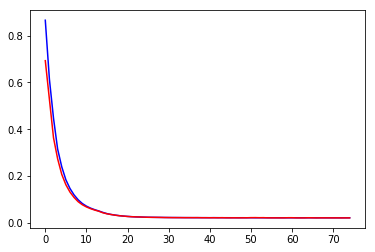

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_res.history['categorical_crossentropy'],'b')
plt.plot(train_res.history['val_categorical_crossentropy'],'r')
plt.show()

In [12]:
test_predictions = final_model.predict([test_matrices_padded, test_headers_padded, test_connectivities_padded])

In [13]:
test_class_pred = test_predictions.argmax(axis=2)
print(test_class_pred.shape)

(2476, 29)


In [14]:
test_class_act = test_headers_padded.argmax(axis=2)
print(test_class_act.shape)

(2476, 29)


In [15]:
test_errors = test_class_act != test_class_pred

In [16]:
err_rate = 100*np.sum(np.sum(test_errors))/float(test_class_act.shape[0]*test_class_act.shape[1])
print('test error rate is ' + str(err_rate))

test error rate is 55.709988301487385


In [17]:
def sample_gumbel(shape, eps=1e-20): 
  """Sample from Gumbel(0, 1)"""
  U = tf.random_uniform(shape,minval=0,maxval=1)
  return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
  """ Draw a sample from the Gumbel-Softmax distribution"""
  y = logits + sample_gumbel(tf.shape(logits))
  return tf.nn.softmax( y / temperature)

def gumbel_softmax(logits, temperature, hard=False):
  """Sample from the Gumbel-Softmax distribution and optionally discretize.
  Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
  Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
  """
  y = gumbel_softmax_sample(logits, temperature)
  if hard:
    k = tf.shape(logits)[-1]
    #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
    y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
    y = tf.stop_gradient(y_hard - y) + y
  return y

In [18]:
def zero_atom_trimmer(untrimmed_nodes):
    trimmed_nodes = untrimmed_nodes[:,:,1:6]
    return(trimmed_nodes)


In [19]:
gumbel_softmax_mask = lambda x: gumbel_softmax(logits=x,temperature=0.05)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dropout
## first step is to generate a node label vector 
def node_gen(latent_dim,num_nodes,atom_types):
    inputLayer = keras.layers.Input(shape=(latent_dim,))
    first_dense = keras.layers.Dense(128, name="first_gen_dense")(inputLayer)
    first_leaky = LeakyReLU(alpha=0.3,name="first_gen_LReLU")(first_dense)
    first_drop = Dropout(rate = 0.15,name="first_gen_dropout")(first_leaky)
    second_dense = keras.layers.Dense(128,name="second_gen_dense")(first_drop)
    second_leaky = LeakyReLU(alpha=0.3,name="second_gen_LReLU")(second_dense)
    second_drop = Dropout(rate = 0.15,name="second_gen_dropout")(second_leaky)
    third_dense = keras.layers.Dense(num_nodes*64*atom_types, name="third_gen_dense")(second_drop)
    third_leaky = LeakyReLU(alpha=0.3,name="third_gen_LReLU")(third_dense) 
    first_drop = Dropout(rate = 0.15,name="first_gen_dropout")(first_leaky)
    node_reshape = keras.layers.Reshape((num_nodes,64*atom_types),name="reshape")(third_leaky)
    #node_probs = keras.layers.Dense(atom_types, activation='softmax')(node_reshape)
    node_logits = keras.layers.Dense(atom_types, activation='linear',name="linear_logits")(node_reshape)
    node_samples = keras.layers.Lambda(gumbel_softmax_mask,name="gumbel_softmax")(node_logits)
    node_trim = keras.layers.Lambda(zero_atom_trimmer,name="trim_samples")(node_samples)
    node_model = keras.models.Model(inputs=[inputLayer],outputs=[node_trim])
    return(node_model)



In [20]:
gm = node_gen(latent_dim=100,num_nodes=29,atom_types=6)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


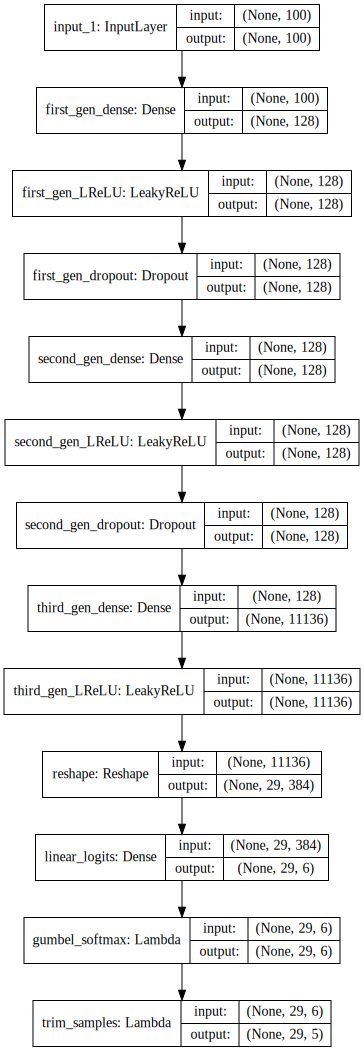

In [21]:
SVG(model_to_dot(gm,show_shapes=True).create(prog='dot', format='svg'))

In [22]:
def node_discriminator(node_size,atom_types):
    inputLayer = keras.layers.Input(shape=(node_size,atom_types))
    first_dense = keras.layers.Dense(32, activation='relu',name="first_desc_dense")(inputLayer)
    second_dense = keras.layers.Dense(16, activation='relu',name="second_desc_dense")(first_dense)
    node_reshape = keras.layers.Reshape((num_nodes*16,),name="reshape")(second_dense)
    node_probs = keras.layers.Dense(1, activation='sigmoid',name='readout')(node_reshape)
    disc_model = keras.models.Model(inputs=[inputLayer],outputs=[node_probs])
    return(disc_model)

In [23]:
num_input =5 
latent_dim = 50
noise_input = np.random.randn(num_input,latent_dim)
num_nodes = 29

In [91]:
class afgan:
    def __init__(self,num_nodes, atom_types, latent_dim):
        self.num_nodes = num_nodes
        self.atom_types = atom_types
        self.latent_dim = latent_dim
        self.epoch_history = {'G_loss':[],
                         'G_accuracy':[],
                         'D_loss':[],
                         'D_accuracy':[],
                        'step':0}
        

    def create_stacked(self,generator_fun, discriminator_fun):
        
        stack_input= keras.layers.Input((self.latent_dim,))
        self.D  = discriminator_fun(node_size=self.num_nodes,
                                    atom_types=self.atom_types)
        
        self.D.trainable =  True
        self.D.compile(loss='binary_crossentropy',optimizer=keras.optimizers.adam(lr=1e-4),
                       metrics=['accuracy'])
        
        
        
        self.G = generator_fun(latent_dim=self.latent_dim,num_nodes=self.num_nodes,
                               atom_types=self.atom_types+1)
        
        self.D.trainable =  False
        self.G.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
        self.combined = keras.models.Model(inputs=stack_input, outputs=self.D(self.G(stack_input)))
        self.combined.compile(loss='binary_crossentropy',optimizer='Adadelta', metrics=['accuracy'])
    def sample_generator(self,samples):
        # generate synthetic nodes
        gen_noise = np.random.randn(samples,self.latent_dim)
        synthetic_nodes = self.G.predict(gen_noise)
        
        return(synthetic_nodes)
    
    def training_iteration(self,trainning_data, batch, disc_tol = 0.55, gen_tol = 0.99,
                          train_disc=False, train_gen= True):
        
    
        
        # create a random shuffle
        data_length = trainning_data.shape[0]
        this_shuffled_train = copy.copy(trainning_data)
        np.random.shuffle(this_shuffled_train)
       

        num_batches = int(np.ceil(float(data_length)/batch))
        start = 0
        end = batch
        # loop over batches 
        for i in range(0,num_batches):
            self.epoch_history['step'] += 1
            this_batch = this_shuffled_train[start:end, :, :]
            batchlen = end - start
            start += batch
            end = min(end+batch,data_length)



            # make some fake samples from gen
            # generate synthetic nodes
            synthetic_nodes = self.sample_generator(samples=batchlen)

            # combine real and fake labels
            x_combined_batch = np.concatenate((this_batch, synthetic_nodes))
            y_combined_batch_noise = np.concatenate((np.abs(np.random.normal(loc=0.9,scale=0.05,size=(np.int64(batchlen), 1))),
                                               np.abs(np.random.normal(loc=0.1,scale=0.05,size=(np.int64(batchlen), 1)))))
            y_combined_batch_pure = np.concatenate((np.ones((np.int64(batchlen), 1)),                                                    
                                                    np.zeros((np.int64(batchlen), 1))))

            # train discriminator

            if train_disc:
                disc_hist_unused = self.D.train_on_batch(x_combined_batch, y_combined_batch_noise)

            disc_hist = self.D.evaluate(x_combined_batch, y_combined_batch_pure, verbose=0)

            self.epoch_history['D_loss'].append(disc_hist[0])
            self.epoch_history['D_accuracy'].append(disc_hist[1])


            # make a full sample random input
            input_noise = np.random.randn(batchlen,self.latent_dim)
            y_mislabled = np.ones((batchlen, 1))


            if train_gen:
                gen_hist = self.combined.train_on_batch(input_noise, y_mislabled)
            else:
                gen_hist = self.combined.evaluate(input_noise, y_mislabled, verbose=0)


            self.epoch_history['G_loss'].append(gen_hist[0])
            self.epoch_history['G_accuracy'].append(gen_hist[1])
            
            D_acc = disc_hist[1]
            G_acc = gen_hist[1]
            
            if D_acc < disc_tol:
                train_disc=True
            else:
                train_disc=False
            if G_acc < gen_tol:
                train_gen=True
            else:
                train_gen=False

        return([disc_hist,gen_hist])

            


In [159]:
mygan = afgan(num_nodes=29, atom_types=5, latent_dim=100)

In [160]:
mygan.create_stacked(generator_fun = node_gen, discriminator_fun=node_discriminator)

In [161]:
#mygan.D.evaluate(headers_padded[0:10,:,:],np.ones((10,1)))

In [226]:

for i in range(0,10):
  
    epoch_history = mygan.training_iteration(trainning_data = headers_padded, batch = 1000,
                                             disc_tol = 0.90, gen_tol = 0.90,
                                             train_disc=False, train_gen= True)
    D_acc = epoch_history[0][1]
    G_acc = epoch_history[1][1]
print(epoch_history)
    

[[0.6672213177680969, 0.879], [0.6976824, 0.143]]


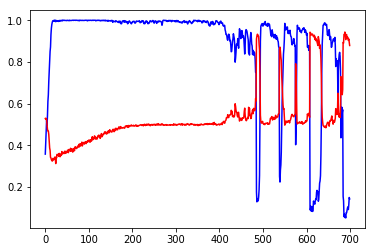

In [227]:
import matplotlib.pyplot as plt
plt.plot(mygan.epoch_history['G_accuracy'],'b')
plt.plot(mygan.epoch_history['D_accuracy'],'r')
plt.show()

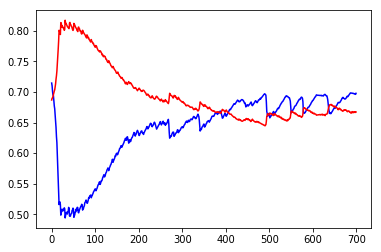

In [228]:
import matplotlib.pyplot as plt
plt.plot(mygan.epoch_history['G_loss'],'b')
plt.plot(mygan.epoch_history['D_loss'],'r')
plt.show()

In [237]:
mapping_dict = {0.0:"",1.0:"H",2.0:"C",3.0:"N",4.0:"O",5.0:"F"}
fk = mygan.sample_generator(samples=1).argmax(axis=2)[0]
wrd = "".join([mapping_dict[float(i)] for i in fk])
print(wrd)
sensible_wrd = ":".join(['C',str(wrd.count('C')),' H',str(wrd.count('H')),' N',str(wrd.count('N')),
                         ' O',str(wrd.count('O')),' F',str(wrd.count('F'))])
print(sensible_wrd)

CHHHHCOCCHH
C:4: H:6: N:0: O:1: F:0


In [42]:
mapping_dict = {0.0:"",1.0:"H",2.0:"C",3.0:"N",4.0:"O",5.0:"F"}
fk = mygan.sample_generator(samples=1).argmax(axis=2)[0]
wrd = "".join([mapping_dict[float(i)] for i in fk])
print(wrd)
sensible_wrd = ":".join(['C',str(wrd.count('C')),' H',str(wrd.count('H')),' N',str(wrd.count('N')),
                         ' F',str(wrd.count('F'))])
print(sensible_wrd)

OHNHOCNNNHNOC
C:2: H:3: N:5: F:0


In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(mygan.G,show_shapes=True).create(prog='dot', format='svg'))


In [ ]:
mygan.G.summary()

In [ ]:
mygan.D.predict(mygan.G.predict(np.random.randn(1,latent_dim)))

In [ ]:
fk=mygan.G.predict(np.random.randn(3,latent_dim)).argmax(axis=2)[0]
wrd = "".join([mapping_dict[float(i)] for i in fk])

In [ ]:
fk

In [ ]:
bond_types = 3
minimal_mats = None
for m in matrices_padded:
    minimal_m = minimalize_BO_matrix(m,num_nodes)
    if minimal_mats is None:
        minimal_mats = minimal_m.reshape((1,(num_nodes*num_nodes - num_nodes)/2,bond_types))
        print(minimal_mats.shape)
    else:    
        minimal_mats = np.concatenate([minimal_mats,minimal_m.reshape((1,(num_nodes*num_nodes - num_nodes)/2,bond_types))],
                                      axis=0)

In [ ]:
def get_bonding_mask(nodeslist, bond_types=3):
    print(nodeslist.shape)
    populated_nodes  = np.diag(np.sum(nodeslist,axis=2))
    print(populated_nodes.shape)
    all_bonds = np.ones((len(nodeslist),len(nodeslist))) - np.identity(len(nodeslist))
    vector_mask = generate_vector(np.matmul(populated_nodes,all_bonds),len(nodeslist))
    vector_mask=np.repeat(np.reshape(vector_mask,(len(vector_mask),2)),bond_types,axis=1)
    return(vector_mask)
    

In [ ]:
def zero_bond_trimmer(untrimmed_nodes):
    print(untrimmed_nodes.shape)
    trimmed_nodes = untrimmed_nodes[:,1:5]
    return(trimmed_nodes)    

In [ ]:
from keras.layers import Input, Dense

def deterministic_edge_reconstructor(num_nodes=29,atom_types=5,bond_types=3):
        num_edges = (num_nodes*num_nodes -num_nodes)/2

        inputBOLayer = Input(shape=(num_nodes,atom_types,))
        first_dense = keras.layers.Dense(128, name="first_BO_dense")(inputBOLayer)
        first_leaky = LeakyReLU(alpha=0.3,name="first_BO_LReLU")(first_dense)

        ## find the legal masking
        #atomsum = keras.layers.Add(get_bonding_mask, name='bond_masks')(inputBOLayer)
        #bo_mask = keras.layers.Lambda(get_bonding_mask, name='bond_masks')(inputBOLayer)


        second_dense = keras.layers.Dense(num_edges*(bond_types+1)/num_nodes,name="second_BO_dense")(first_leaky)
        second_leaky = LeakyReLU(alpha=0.3,name="second_gen_LReLU")(second_dense)
        bo_reshape = keras.layers.Reshape((num_edges,bond_types+1),name="reshape")(second_dense)
        #bo_legalize = keras.layers.Multiply(name='mask apply')[bo_reshape,bo_mask]

        bo_logits = keras.layers.Dense(bond_types+1, activation='linear',name="linear_logits")(bo_reshape)
        bo_samples = keras.layers.Lambda(gumbel_softmax_mask,name="gumbel_softmax")(bo_logits)
#        bo_trim = keras.layers.Lambda(zero_bond_trimmer,name="trim_samples")(bo_samples)

        bo_model = keras.models.Model(inputs=[inputBOLayer],outputs=[bo_samples])
        return(bo_model)

In [ ]:
minimal_mats.shape

In [ ]:
np.random.seed(3)
# get random partition
msk = np.random.rand(np.shape(headers_padded)[0]) < 0.75
# test and train split
train_matrices_minimal = minimal_mats[msk,:,:]
train_headers_padded = headers_padded[msk,:]
train_connectivities_padded = connectivities_padded[msk,:,:]
test_matrices_minimal_mats = minimal_mats[~msk,:,:]
test_headers_padded = headers_padded[~msk,:]
test_connectivities_padded = connectivities_padded[~msk,:,:]

In [ ]:
## def zero-ize bond orders

In [ ]:
test_matrices_minimal_mats.shape

In [ ]:
bo_model_n = deterministic_edge_reconstructor()
bo_model_n.compile(optimizer=keras.optimizers.adam(lr=1e-6),loss='categorical_crossentropy',
                 metrics=['categorical_accuracy','categorical_crossentropy'])

In [ ]:
bo_model_n.predict(train_headers_padded).shape

In [ ]:
tp = bo_model_n.predict(train_headers_padded)

In [ ]:
tp[0]

In [ ]:
train_matrices_minimal.shape

In [ ]:
SVG(model_to_dot(bo_model_n,show_shapes=True).create(prog='dot', format='svg'))


In [ ]:
res = bo_model_n.fit(train_headers_padded,train_matrices_minimal,epochs=1, batch_size=750,
                            validation_split=0.1,
                            verbose=True)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(res.history['categorical_accuracy'])
plt.plot(res.history['val_categorical_accuracy'],'r')
plt.show()

In [ ]:
# test predictions
test_predictions = bo_model.predict(test_headers_padded)
test_res = bo_model.evaluate(test_headers_padded,test_matrices_minimal_mats)
print(test_res)

#test_class_pred = test_predictions.argmax(axis=2)
#test_class_pred = test_predictions.argmax(axis=2)
#err_rate = 100*np.sum(np.sum(test_errors))/float(test_class_act.shape[0]*test_class_act.shape[1])
#print('test error rate is ' + str(err_rate))


In [ ]:
test_predictions[0]

In [ ]:
test_predictions

In [ ]:
zta = (0.2)*np.ones((test_predictions.shape[0],test_predictions.shape[1],1))
print(zta.shape)

In [ ]:
test_augment = np.concatenate([np.zeros((test_predictions.shape[0],test_predictions.shape[1],1)),test_predictions],axis=2)
test_class= test_augment.argmax(axis=2)

In [ ]:
test_augment[0]

In [ ]:
test_augment[0].argmax(axis=1)

In [ ]:
len(msk)

In [ ]:
mm = minimal_mats[0:1].squeeze()
bms = mm.argmax(axis=1)
print(bms)

In [ ]:
pos.argmax(axis=2)

In [ ]:
headers_padded[0:1]

In [ ]:
gumbel_softmax_mask = lambda x: gumbel_softmax(logits=x,temperature=0.05)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dropout
## first step is to generate a node label vector 
def bo_gen(latent_dim,num_nodes,atom_types):
    inputLayer = keras.layers.Input(shape=(latent_dim,))
    first_dense = keras.layers.Dense(128, name="first_gen_dense")(inputLayer)
    first_leaky = LeakyReLU(alpha=0.3,name="first_gen_LReLU")(first_dense)
    first_drop = Dropout(rate = 0.15,name="first_gen_dropout")(first_leaky)
    second_dense = keras.layers.Dense(128,name="second_gen_dense")(first_drop)
    second_leaky = LeakyReLU(alpha=0.3,name="second_gen_LReLU")(second_dense)
    second_drop = Dropout(rate = 0.15,name="second_gen_dropout")(second_leaky)
    third_dense = keras.layers.Dense(num_nodes*64*atom_types, name="third_gen_dense")(second_drop)
    third_leaky = LeakyReLU(alpha=0.3,name="third_gen_LReLU")(third_dense) 
    first_drop = Dropout(rate = 0.15,name="first_gen_dropout")(first_leaky)
    node_reshape = keras.layers.Reshape((num_nodes,64*atom_types),name="reshape")(third_leaky)
    #node_probs = keras.layers.Dense(atom_types, activation='softmax')(node_reshape)
    node_logits = keras.layers.Dense(atom_types, activation='linear',name="linear_logits")(node_reshape)
    node_samples = keras.layers.Lambda(gumbel_softmax_mask,name="gumbel_softmax")(node_logits)
    node_trim = keras.layers.Lambda(zero_atom_trimmer,name="trim_samples")(node_samples)
    node_model = keras.models.Model(inputs=[inputLayer],outputs=[node_trim])
    return(node_model)


In [ ]:
29*3

In [ ]:
minimal_mats.shape

In [ ]:
"".join([mapping_dict[float(i)] for i in fk])

In [ ]:
"".join([mapping_dict[float(i)] for i in rl])

In [ ]:
wrd.count('C')

In [ ]:
wrd.count('H')

In [ ]:
headers_onehot_dict

In [ ]:
SVG(model_to_dot(combined,show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
combined.summary()

In [ ]:
combined.predict(noise_input)

In [ ]:
num_input  = 100

In [ ]:
# generate synthetic nodes
gen_noise = np.random.randn(num_input,latent_dim)
synthetic_nodes = gen_mods.predict(gen_noise)
print(synthetic_nodes.shape)

In [ ]:
real_nodes = headers_padded[0:100,:,:]
print(real_nodes.shape)
batch = 200

In [ ]:
x_combined_batch = np.concatenate((real_nodes, synthetic_nodes))
y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

In [ ]:
y_combined_batch.shape

In [ ]:
## train discriminator
disc_hist = disc_model.fit(x_combined_batch, y_combined_batch,epochs=4, verbose=1)

In [ ]:
disc_hist = disc_model.train_on_batch(x_combined_batch, y_combined_batch)

In [ ]:
disc_hist

In [ ]:
# create a batch of synthetic noises
noise = np.random.normal(0, 1, (batch, latent_dim))
y_mislabled = np.ones((batch, 1))

In [ ]:
gen_hist = combined.fit(noise, y_mislabled,epochs=500, batch_size=10, verbose=1)

In [ ]:
disc_model.predict(synthetic_nodes[0:10,:,:])

In [ ]:
synthetic_nodes[0,:,:].argmax(axis=1)

In [ ]:
headers_padded[0,:,:].argmax(axis=1)

In [ ]:
batch = 120


print(data_length)


In [ ]:
print(float(data_length)/batch)

In [ ]:
print(num_batches)

In [ ]:
noise_input